In [1]:
%config IPCompleter.use_jedi = False
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 2
import sys
import traceback # for stack trace formatting
import importlib
from pathlib import Path
from benedict import benedict
import numpy as np

import os

import pandas as pd

# # os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
# # os.environ["MODIN_ENGINE"] = "unidist" # Modin will use Unidist
# # os.environ["UNIDIST_BACKEND"] = "mpi" # Unidist will use MPI backend
# import modin.pandas as pd # alternative to pandas which is much faster
# # Installed with `poetry add modin[all]`

# from pandas_profiling import ProfileReport ## for dataframe viewing

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
from benedict import benedict # https://github.com/fabiocaccamo/python-benedict#usage

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.print_helpers import print_keys_if_possible, print_value_overview_only, document_active_variables, objsize, print_object_memory_usage, debug_dump_object_member_shapes, TypePrintMode
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_time_str, get_now_time_precise_str

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths

# from PendingNotebookCode import _perform_batch_plot, _build_batch_plot_kwargs
from pyphoplacecellanalysis.General.Batch.NonInteractiveWrapper import batch_load_session, batch_extended_computations, SessionBatchProgress, batch_programmatic_figures, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

session_batch_status = {}
session_batch_errors = {}
enable_saving_to_disk = False

global_data_root_parent_path = Path(r'W:\Data') # Windows Apogee
# global_data_root_parent_path = Path(r'/media/MAX/Data') # Diba Lab Workstation Linux
# global_data_root_parent_path = Path(r'/Volumes/MoverNew/data') # rMBP
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=self.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

## Animal `gor01`:
local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='one') # IdentifyingContext<('kdiba', 'gor01', 'one')>
local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # 'gor01', 'one'
local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['PhoHelpers', 'Spike3D-Minimal-Test', 'Unused'])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

### Animal `vvp01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# ### Animal `pin01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='pin01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # no exper_name ('one' or 'two') folders for this animal.
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['redundant','showclus','sleep','tmaze'])

## Build session contexts list:
local_session_contexts_list = [local_session_parent_context.adding_context(collision_prefix='sess', session_name=a_name) for a_name in local_session_names_list] # [IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-07_11-26-53')>, ..., IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-13_14-42-6')>]

## Initialize `session_batch_status` with the NOT_STARTED status if it doesn't already have a different status
for curr_session_basedir in local_session_paths_list:
    curr_session_status = session_batch_status.get(curr_session_basedir, None)
    if curr_session_status is None:
        session_batch_status[curr_session_basedir] = SessionBatchProgress.NOT_STARTED # set to not started if not present
        # session_batch_status[curr_session_basedir] = SessionBatchProgress.COMPLETED # set to not started if not present

session_batch_status

local_session_names_list: ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']


{WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-07_11-26-53'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-08_14-26-15'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_3-23-37'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-12_15-55-31'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-13_14-42-6'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>}

In [3]:
%pdb off
# %%viztracer
basedir = local_session_paths_list[1] # NOT 3
print(f'basedir: {str(basedir)}')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# epoch_name_whitelist = ['maze']
epoch_name_whitelist = None
active_computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        # '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_time_dependent_pf_sequential_surprise_computation'
                                        '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                    ]
curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_whitelist=epoch_name_whitelist,
                                          computation_functions_name_whitelist=active_computation_functions_name_whitelist,
                                          saving_mode=PipelineSavingScheme.SKIP_SAVING, force_reload=False, skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True)

Automatic pdb calling has been turned OFF
basedir: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15
Loading loaded session pickle file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl... done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl.
property already present in pickled version. No need to save.
using provided computation_functions_name_whitelist: ['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation', '_perform_position_decoding_computation', '_perform_firing_rate_trends_computation', '_perform_two_step_position_decoding_computation']
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions c

# 2023-02-24 Decoders 
- [ ] where are cells chosen for inclusion in the input of the decoder?

In [ ]:
long_epoch_name, short_epoch_name, global_epoch_name = long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]

recalculate_anyway = False

In [ ]:
# Make the 1D Placefields and Decoders conform between the long and the short epochs:
long_pf1D = long_results.pf1D
short_pf1D = short_results.pf1D
global_pf1D = global_results.pf1D

# short_pf1D, did_update_bins = short_pf1D.conform_to_position_bins(long_pf1D, force_recompute=True) # not needed because it's done in one_step_decoder_1D.conform_to_position_bins(...)
long_one_step_decoder_1D, short_one_step_decoder_1D  = [results_data.get('pf1D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_1D, did_recompute = short_one_step_decoder_1D.conform_to_position_bins(long_one_step_decoder_1D, force_recompute=True)

## Build or get the two-step decoders for both the long and short:
long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
if recalculate_anyway or did_recompute or (long_two_step_decoder_1D is None) or (short_two_step_decoder_1D is None):
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
    long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
    assert (long_two_step_decoder_1D is not None and short_two_step_decoder_1D is not None)

decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333
# decoding_time_bin_size = 0.03 # 0.03333333333333333
print(f'decoding_time_bin_size: {decoding_time_bin_size}')

#### Get 2D Decoders for validation and comparisons:

In [ ]:
# Make the 2D Placefields and Decoders conform between the long and the short epochs:
long_pf2D = long_results.pf2D
short_pf2D = short_results.pf2D
global_pf2D = global_results.pf2D

# long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
# long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]

# short_pf2D, did_update_bins = short_pf2D.conform_to_position_bins(long_pf2D)
long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_2D, did_recompute = short_one_step_decoder_2D.conform_to_position_bins(long_one_step_decoder_2D)

## Build or get the two-step decoders for both the long and short:
long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
if recalculate_anyway or did_recompute or (long_two_step_decoder_2D is None) or (short_two_step_decoder_2D is None):
    curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
    long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
    assert (long_two_step_decoder_2D is not None and short_two_step_decoder_2D is not None)

In [ ]:
# Sums are similar:
print(f'{np.sum(long_one_step_decoder_2D.marginal.x.p_x_given_n) =},\t {np.sum(long_one_step_decoder_1D.p_x_given_n) = }') # 31181.999999999996 vs 31181.99999999999

## Validate:
assert long_one_step_decoder_2D.marginal.x.p_x_given_n.shape == long_one_step_decoder_1D.p_x_given_n.shape, f"Must equal but: {long_one_step_decoder_2D.marginal.x.p_x_given_n.shape =} and {long_one_step_decoder_1D.p_x_given_n.shape =}"
assert long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape == long_one_step_decoder_1D.most_likely_positions.shape, f"Must equal but: {long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape =} and {long_one_step_decoder_1D.most_likely_positions.shape =}"

## validate values:
assert np.allclose(long_one_step_decoder_2D.marginal.x.p_x_given_n, long_one_step_decoder_1D.p_x_given_n), f"1D Decoder should have an x-posterior equal to its own posterior"
assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"

In [ ]:
# Gate the spikes that are coming in to build the decoder... those are from the placefields actually.
    # so it'll be gating the placefield cells.
    
active_config_name = 'maze1'
active_pf_1D = long_pf1D
# curr_active_pipeline.computation_results['maze'].

# Testing Placefields:

In [4]:
import matplotlib.pyplot as plt
%matplotlib qt

from neuropy.utils.misc import split_list_of_dicts
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.analyses.placefields import PfND
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from PendingNotebookCode import _compute_parameter_sweep

In [5]:
# - [ ] Test that changing the position bins post-hoc is equivalent to initially computing with those position bins

## Get testing variables from `curr_active_pipeline`

In [4]:
sess = curr_active_pipeline.filtered_sessions['maze']
spikes_df = curr_active_pipeline.sess.spikes_df
pyramidal_only_spikes_df = deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal') ## get only the pyramidal spikes
active_pos = curr_active_pipeline.sess.position
active_pos_df = active_pos.to_dataframe()

In [ ]:
## Save for NeuroPy testing:
finalized_output_cache_file='../NeuroPy/tests/neuropy_pf_testing.h5'
sess_identifier_key='sess'
spikes_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/spikes_df')
active_pos.to_dataframe().to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/pos_df', format='table')

## Load testing variables from file 'NeuroPy/tests/neuropy_pf_testing.h5'

In [ ]:
""" Corresponding load for Neuropy Testing file 'NeuroPy/tests/neuropy_pf_testing.h5': 
    ## Save for NeuroPy testing:
    finalized_output_cache_file='../NeuroPy/tests/neuropy_pf_testing.h5'
    sess_identifier_key='sess'
    spikes_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/spikes_df')
    active_pos.to_dataframe().to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/pos_df', format='table')
"""
finalized_output_cache_file='../NeuroPy/tests/neuropy_pf_testing.h5'
sess_identifier_key='sess'
# Load the saved .h5 spikes_df and active_pos dataframes for testing:
spikes_df = pd.read_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/spikes_df')
pyramidal_only_spikes_df = deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal') ## get only the pyramidal spikes

active_pos_df = pd.read_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/pos_df')
active_pos = active_pos_df.position.to_Position_obj() # convert back to a full position object

## Conduct Parameter Sweeps

In [ ]:
# smooth_options = [(None, None), (0.5, 0.5), (1.0, 1.0), (2.0, 2.0), (5.0, 5.0)]
# grid_bin_options = [(1,1),(5,5),(10,10)]
# grid_bin_options = [(5,5)]
# param_sweep_option_n_values = dict(smooth=len(smooth_options), grid_bin=len(grid_bin_options)) 

smooth_options = [(None, None), (0.5, 0.5), (1.0, 1.0)]
grid_bin_options = [(0.5, 0.5), (1.0, 1.0), (2.0, 2.0), (5.0, 5.0)]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(smooth=smooth_options, grid_bin=grid_bin_options)
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)

In [ ]:
speed_thresh_options = [0.0, 1.0, 25.0, 50.0, 100.0, 200.0]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(speed_thresh=speed_thresh_options)
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)
print_aligned_columns(['speed_thresh', 'num_good_neurons', 'num_total_spikes'], [speed_thresh_options, num_good_placefield_neurons_list, num_total_spikes_list])

In [ ]:
frate_thresh_options = [0.0, 0.1, 1.0, 5.0, 10.0, 100.0]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(frate_thresh=frate_thresh_options)
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)
print_aligned_columns(['frate_thresh', 'num_good_neurons', 'num_total_spikes'], [frate_thresh_options, num_good_placefield_neurons_list, num_total_spikes_list])

In [ ]:
fig, axs = _plot_parameter_sweep(output_pfs, param_sweep_option_n_values)

In [ ]:
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=0.1) # TODO: FIXME: BUG: when frate_thresh=0.0, there are 0 good placefield_neuronIDs for all computations!

### PfND_TimeDependent Parameter Sweeps:

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot

# PfND_TimeDependent
orginal_pf1D_dt = PfND_TimeDependent(deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal'), deepcopy(active_pos.linear_pos_obj), frate_thresh=0.0)
orginal_pf1D_dt

# 2023-03-03 - Decoder Testing
Useful Decoder-related plotting and visuzliation classes:
```python
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
```

In [ ]:
%load_ext viztracer
from viztracer import VizTracer

from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder

In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-build_new_PfND.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    ## Build placefield for the decoder to use:
    original_pf1D = PfND(deepcopy(pyramidal_only_spikes_df), deepcopy(active_pos.linear_pos_obj), frate_thresh=0.0) # all other settings default

    new_decoder_pf_params = deepcopy(original_pf1D.config) # should be a PlacefieldComputationParameters
    # override some settings before computation:
    new_decoder_pf_params.time_bin_size = 0.1

    ## 1D Decoder
    new_decoder_pf1D = original_pf1D
    new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()

    # Why would it need both the pf1D and the spikes? Doesn't the pf1D include the spikes (and determine the placefields, which are all that are used)???
    new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, debug_print=False)
    new_1D_decoder.compute_all()

    print(f'done!')

In [ ]:
new_1D_decoder.time_bin_size

In [ ]:
original_decoder = new_1D_decoder # strangely this makes original_pf.included_neuron_IDs wrapped in an extra list!
original_neuron_ids = np.array(original_decoder.pf.ratemap.neuron_ids) # original_pf.included_neuron_IDs
subset_included_neuron_IDXs = np.arange(10) # only get the first 10 neuron_ids
subset_included_neuron_ids = original_neuron_ids[subset_included_neuron_IDXs] # only get the first 10 neuron_ids
print(f'{original_neuron_ids = }\n{subset_included_neuron_ids = }')
neuron_sliced_1D_decoder = original_decoder.get_by_id(subset_included_neuron_ids)

In [ ]:
neuron_sliced_1D_decoder.neuron_IDXs

In [ ]:
PfND
get_by_id()

## Specific Epoch Decoding:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

In [ ]:
## Lap-Epochs Decoding:
sess = curr_active_pipeline.filtered_sessions['maze']
active_decoder = new_1D_decoder
decoding_time_bin_size = 0.02
global_pos_df = sess.position.to_dataframe()

laps_copy = deepcopy(sess.laps)
laps_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(6)).as_epoch_obj() # epoch object
laps_filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=laps_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
laps_filter_epochs_decoder_result.epoch_description_list = [f'lap[{epoch_tuple.lap_id}]' for epoch_tuple in laps_filter_epochs.to_dataframe()[['lap_id']].itertuples()] # Short

In [ ]:
laps_plot_tuple = plot_decoded_epoch_slices(laps_filter_epochs, laps_filter_epochs_decoder_result, global_pos_df=global_pos_df, variable_name='lin_pos', xbin=active_decoder.xbin,
                                                        name='stacked_epoch_slices_matplotlib_subplots_LAPS', debug_print=True)

In [ ]:
# create legend object and add to figure
last_axes = list(laps_plot_tuple[2].axs)[-1]
last_axes.legend()

In [ ]:
laps_plot_tuple[2].fig

In [ ]:
out_legend = laps_plot_tuple[2].fig.legend(handles=list(laps_plot_tuple[2].axs), labels=[p.get_label() for p in list(laps_plot_tuple[2].axs)], loc='lower center', ncol=4) #
out_legend

## "Leave-one-out" decoding:

2023-03-09 - IDEA - 9/10 - "Each Decoded time-bin's Neuronal Contribution" - In addition to the performance be measured for the whole decoded epoch (mean squared error across all decoded time bins in an epoch) we could also look at it for each time bin at a time.
That means at a given time bin we'd have a vector that reflects how much error is introduced by leaving out a certain cell. Since the animal is at a fixed place in each time bin (approximately) we expect most cells to contribute little to the decoding of that bin and a few cells (the ones with that place field) to contribute a lot.


In [18]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import perform_leave_one_aclu_out_decoding_analysis
from neuropy.core.epoch import Epoch

## Lap-Epochs Decoding:
sess = curr_active_pipeline.sess
decoding_time_bin_size = 0.02
# decoding_time_bin_size = 0.5

In [10]:
# Common for all decoders:
laps_copy = deepcopy(sess.laps)
active_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(20)).as_epoch_obj() # epoch object
filter_epoch_description_list = [f'lap[{epoch_tuple.lap_id}]' for epoch_tuple in active_filter_epochs.to_dataframe()[['lap_id']].itertuples()]

### active_filter_epochs: sess.replay:

In [24]:
active_filter_epochs = sess.replay.epochs.get_valid_df().epochs.get_epochs_longer_than(minimum_duration=5.0*decoding_time_bin_size).epochs.get_non_overlapping_df()
if not 'stop' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()
    
if not 'label' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['label'] = active_filter_epochs['flat_replay_idx'].copy()

active_filter_epochs = Epoch(active_filter_epochs)
active_filter_epochs

        start      stop label  duration
0      18.681    18.814     0     0.133
1      39.628    39.987     1     0.359
2      40.143    40.328     2     0.185
3      40.939    41.364     3     0.425
4      41.603    41.709     4     0.106
..        ...       ...   ...       ...
609  2083.281  2083.917   609     0.636
610  2083.948  2085.115   610     1.167
611  2087.262  2088.143   611     0.881
612  2089.425  2090.315   612     0.890
613  2091.431  2091.929   613     0.498

[614 rows x 4 columns]

In [25]:
original_1D_decoder, one_left_out_decoder_dict, one_left_out_filter_epochs_decoder_result_dict, one_left_out_omitted_aclu_distance_df, most_contributing_aclus = perform_leave_one_aclu_out_decoding_analysis(pyramidal_only_spikes_df, active_pos_df, active_filter_epochs)

	 spikes_df[time_variable_name]: (58871,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57801,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57325,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57666,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (56364,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (56973,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57414,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57038,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57617,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57410,) should be less than time_window_edges: (84282,)!
	 spikes_df[time_variable_name]: (57677,) should be less than time_window_edges: (84282,)!

In [26]:
len(one_left_out_filter_epochs_decoder_result_dict[2].most_likely_positions_list) # len(...): 20

# 2023-03-15 - Kamran's Leave-One-Out-Surprise

[9:28 AM] Diba, Kamran
then for bins when cell i fires, you calculate the surprise between cell i’s place field and the posterior probability.

[9:28 AM] Diba, Kamran
(which is calculated by excluding cell i)


#### Minimize binning artifacts by smoothing replay spikes:
[10:26 AM] Diba, Kamran
I think van der Meer (Hippocampus) did a 25ms Gaussian convolution

In [53]:
from scipy import stats # for compute_relative_entropy_divergence_overlap
from scipy.special import rel_entr # alternative for compute_relative_entropy_divergence_overlap

In [27]:
# get only bins where each cell fires:
# original_1D_decoder.is_non_firing_time_bin

In [30]:
# !! WARNING: these don't work because when decoding specific epochs unique bins were actually crafted: 
is_cell_firing_time_bin = (original_1D_decoder.unit_specific_time_binned_spike_counts > 0)
is_cell_firing_time_bin

In [127]:
# Want to accumulate the results for each EPOCH instead of each CELL
all_cells_decoded_epoch_time_bins = {}
all_cells_computed_epoch_surprises = {}

## for each cell:
for i, aclu in enumerate(original_1D_decoder.neuron_IDs):
    # aclu = original_1D_decoder.neuron_IDs[i]
    unit_IDX = original_1D_decoder.neuron_IDXs[i] # should just be i, but just to be safe
    ## TODO: only look at bins where the cell fires (is_cell_firing_time_bin[i])
    curr_cell_tuning_curve = original_1D_decoder.pf.ratemap.tuning_curves[unit_IDX]
    curr_cell_one_left_out_decoder_result = one_left_out_filter_epochs_decoder_result_dict[aclu]
    ## single cell outputs:
    curr_cell_decoded_epoch_time_bins = [] # will be a list of the time bins in each epoch that correspond to each surprise in the corresponding list in curr_cell_computed_epoch_surprises 
    curr_cell_computed_epoch_surprises = [] # will be a list of np.arrays, with each array representing the surprise of each time bin in each epoch
    # have one list of posteriors p_x_given_n for each decoded epoch (active_filter_epochs.n_epochs):
    assert len(curr_cell_one_left_out_decoder_result.p_x_given_n_list) == active_filter_epochs.n_epochs
    for decoded_epoch_idx in np.arange(active_filter_epochs.n_epochs):
        curr_epoch_time_bins = curr_cell_one_left_out_decoder_result.time_bin_containers[decoded_epoch_idx]
        curr_epoch_p_x_given_n = curr_cell_one_left_out_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
        assert curr_epoch_p_x_given_n.shape[0] == curr_cell_tuning_curve.shape[0]
        curr_epoch_surprises = np.array([distance.jensenshannon(curr_cell_tuning_curve, curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T]) # works! Finite! [0.5839003679903784, 0.5839003679903784, 0.6997779781969289, 0.7725622595699131, 0.5992295785891731]
        curr_cell_computed_epoch_surprises.append(curr_epoch_surprises)
        curr_cell_decoded_epoch_time_bins.append(curr_epoch_time_bins)

    assert len(curr_cell_decoded_epoch_time_bins) == len(curr_cell_computed_epoch_surprises)
    all_cells_decoded_epoch_time_bins[aclu] = curr_cell_decoded_epoch_time_bins
    all_cells_computed_epoch_surprises[aclu] = curr_cell_computed_epoch_surprises

In [122]:
# curr_epoch_surprises = distance.jensenshannon(curr_cell_tuning_curve, curr_epoch_p_x_given_n.T)
# curr_epoch_surprises.shape
# print(curr_epoch_surprises)

(239,)

In [47]:
curr_epoch_time_bins.centers

array([18.6935, 18.7185, 18.7435, 18.7685, 18.7935])

In [123]:
curr_cell_tuning_curve.shape

(239,)

In [59]:
np.atleast_2d(curr_cell_tuning_curve).shape

In [124]:
curr_epoch_p_x_given_n.shape

(239, 5)

# Visualize the inputs

In [108]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def visualize_heatmap(data, show_value_labels=False, title="Simple Heatmap", show_xticks=False, show_yticks=False, show_colorbar=False):
    """
    Creates a simple heatmap visualization of the given 2D numpy array data.
    """
    # Reshape the 1D array into a 2D array with a single row
    if data.ndim == 1:
        data = np.reshape(data, (1, -1))
    
    fig, ax = plt.subplots(figsize=(20, 8))
    im = ax.imshow(data)

    if show_colorbar:
        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)

    if show_xticks:
        # Set x-ticks and tick labels
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_xticklabels(np.arange(data.shape[1]))
        # Rotate the x-tick labels and set their alignment
        plt.xticks(rotation=45, ha="right")
        plt.setp(ax.get_xticklabels(), fontsize=8)
    else:
        # Hide x-ticks and tick labels
        ax.set_xticks([])
        ax.set_xticklabels([])

    if show_yticks:
        # Set y-ticks and tick labels
        ax.set_yticks(np.arange(data.shape[0]))
        ax.set_yticklabels(np.arange(data.shape[0]))
    else:
        # Hide y-ticks and tick labels
        ax.set_yticks([])
        ax.set_yticklabels([])

    # Loop over data dimensions and create text annotations.
    if show_value_labels:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                text = ax.text(j, i, data[i, j], ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()
    
    return fig, ax, im

In [105]:
data = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
visualize_heatmap(data)

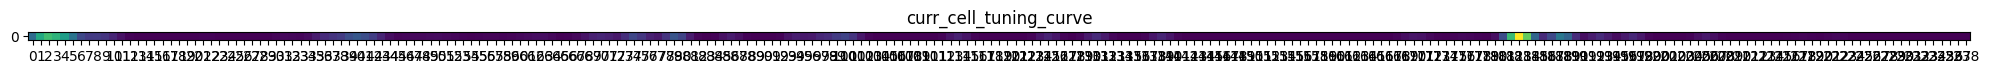

In [106]:
fig, ax, im = visualize_heatmap(curr_cell_tuning_curve, title="curr_cell_tuning_curve")

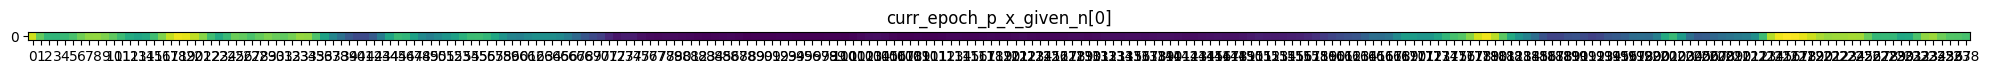

In [96]:
fig, ax, im = visualize_heatmap(curr_epoch_p_x_given_n[:,0], title="curr_epoch_p_x_given_n[0]")

In [95]:
i = 1
fig, ax, im = visualize_heatmap(curr_epoch_p_x_given_n[:,i], title=f"curr_epoch_p_x_given_n[{i}]")

In [99]:
curr_epoch_p_x_given_n.shape

(239, 5)

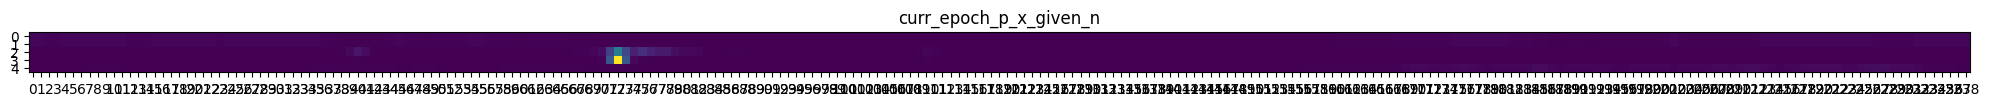

In [107]:
fig, ax, im = visualize_heatmap(curr_epoch_p_x_given_n.T, title=f"curr_epoch_p_x_given_n")

In [93]:
curr_epoch_p_x_given_n.shape

(239, 5)

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability
# out = BasicBinnedImageRenderingWindow(active_eloy_analysis.avg_2D_speed_per_pos, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, name='avg_velocity', title="Avg Velocity per Pos (X, Y)", variable_label='Avg Velocity', scrollability_mode=LayoutScrollability.SCROLLABLE)
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')
# out.add_data(row=2, col=0, matrix=active_pf_2D.ratemap.occupancy, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='occupancy_seconds', title='Seconds Occupancy', variable_label='seconds')
# out.add_data(row=3, col=0, matrix=active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='n_neurons_meeting_firing_critiera_by_position_bins_2D', title='# neurons > 1Hz per Pos (X, Y)', variable_label='# neurons')

# curr_cell_tuning_curve

In [114]:
# Jensen-Shannon distance
from scipy.spatial import distance

# # Chat-GPT's suggested fix: DOES NOT WORK, blows up to inf still and has NaNs
# def log_surprise(placefield, decoded_posterior):
#     # Convert the decoded posterior and placefield to logarithmic form
#     log_decoded_posterior = np.log(decoded_posterior)
#     log_placefield = np.log(placefield)

#     # Compute the log surprise using the modified formula
#     log_surprise = np.sum(np.exp(log_decoded_posterior) * (log_decoded_posterior - log_placefield))

#     # Return the exponentiated log surprise
#     return np.exp(log_surprise)

In [61]:
curr_epoch_surprise = rel_entr(curr_epoch_p_x_given_n, np.atleast_2d(curr_cell_tuning_curve).T)

In [62]:
curr_epoch_surprise.shape

In [64]:
curr_epoch_surprises = [rel_entr(curr_p_x_given_n, curr_cell_tuning_curve) for curr_p_x_given_n in curr_epoch_p_x_given_n.T]

In [68]:
curr_epoch_surprises = [stats.entropy(curr_p_x_given_n, curr_cell_tuning_curve) for curr_p_x_given_n in curr_epoch_p_x_given_n.T] # blows up to infinity at places where pf has zero probability

In [111]:
curr_epoch_surprises = [log_surprise(curr_cell_tuning_curve, curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T] # blows up to infinity and NaN

In [115]:
curr_epoch_surprises = [distance.jensenshannon(curr_cell_tuning_curve, curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T] # works! Finite! [0.5839003679903784, 0.5839003679903784, 0.6997779781969289, 0.7725622595699131, 0.5992295785891731]

[0.5839003679903784, 0.5839003679903784, 0.6997779781969289, 0.7725622595699131, 0.5992295785891731]


In [40]:
curr_cell_one_left_out_decoder_result.p_x_given_n_list[0].shape # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)

In [41]:
curr_cell_one_left_out_decoder_result.p_x_given_n_list[1].shape # .shape: (239, 14) - (n_x_bins, n_epoch_time_bins)

(239, 14)

# one_left_out_filter_epochs_decoder_result_dict[aclu].most_likely_positions_list[epoch_idx]

### Plotting leave-one-out:

In [ ]:
laps_plot_tuple = plot_decoded_epoch_slices(active_filter_epochs,  one_left_out_filter_epochs_decoder_result_dict[2], global_pos_df=active_pos_df, variable_name='lin_pos', xbin=original_1D_decoder.xbin,
                                                        name='stacked_epoch_slices_matplotlib_subplots_LAPS_leave_one_out', debug_print=True)

In [ ]:
 one_left_out_filter_epochs_decoder_result_dict[2]

In [ ]:
one_left_out_omitted_aclu_distance_df

In [ ]:
## 1. Get time-binned spikes during each epoch event

In [ ]:
## 2. Determine the probability of that observed neural sequence given the placefields.
    # - [ ] Issue: this probability only accounts for the cells that are firing, not the ones that aren't firing, right?
    Consider two cells (A and B) that highly correlated (effectively redundant) in a particular environment.
        - IF we observe activity of A without activity B, that is highly suggestive that we are not representing this environment where they are correlated, right? But our likelihood doesn't measure this quanity.
    # - [ ] Issue: The typical conditional probability assumes all cells are independent, which is specifically NOT the case, and especially not for replays.
        
        

In [ ]:
## 3. 

In [ ]:
most_contributing_aclus

In [ ]:
## DEBUG: Get just one of the decoders using a left-out cell:
# left_out_aclu, curr_aclu_omitted_decoder = list(one_left_out_decoder_dict.items())[0]
# left_out_aclu, curr_aclu_omitted_decoder = list(one_left_out_decoder_dict.items())[0]

In [ ]:
# Do a simple plot for comparison:
fig, ax = plt.subplots()
ax.plot(curr_time_bins, window_center_measured_pos_x, label='measured')
# ax.plot(curr_time_bins, curr_most_likely_positions, label=f'omit_{left_out_aclu}')
ax.plot(curr_time_bins, curr_most_likely_valid_positions, label=f'valid only omit_{left_out_aclu}')
plt.legend()
fig.show()

In [ ]:
print(np.shape(pos_x))

In [ ]:
# global_pos_df.resample(
    time_binned_position_df
    interpolate
    
time_binned_position_df = 

In [ ]:
left_out_aclu

In [ ]:
curr_decoder.decode_specific_epochs(

In [ ]:
laps_filter_epochs_decoder_result

In [ ]:
original_1D_decoder.compute_all()

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage

In [ ]:
print_object_memory_usage(original_1D_decoder) # original_1D_decoder - object size: 90.199349 MB

In [ ]:
print_object_memory_usage(one_left_out_laps_filter_epochs_decoder_result_dict) # one_left_out_laps_filter_epochs_decoder_result_dict - object size: 403.150110 MB

In [ ]:
# len(one_left_out_decoder_dict) # 70
print_object_memory_usage(one_left_out_decoder_dict) # object size: 12696.855616 MB

In [ ]:
first_decoder = list(one_left_out_decoder_dict.values())[0]

In [ ]:
first_decoder.decode_specific_epochs(spikes_df=

In [ ]:
first_decoder.save()

In [ ]:
# _perform_specific_epochs_decoding

# 2023-02-27 - Test whether conform to active position works

In [ ]:
## Generate Placefields with varying bin-sizes:
### Here we use frate_thresh=0.0 which ensures that differently binned ratemaps don't have different numbers of spikes or cells.
smooth_options = [(None, None)]
grid_bin_options = [(0.5, 0.5), (1.0, 1.0), (2.0, 2.0), (5.0, 5.0)]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(grid_bin=grid_bin_options, smooth=smooth_options, frate_thresh=[0.0])
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)

In [ ]:
num_good_placefield_neurons_list, num_total_spikes_list, num_spikes_per_spiketrain_list = compare_placefields_info(output_pfs)
print_aligned_columns(['grid_bin x smooth', 'num_good_neurons', 'num_total_spikes'], 
                     [all_param_sweep_options, num_good_placefield_neurons_list, num_total_spikes_list], enable_checking_all_values_width=True)

In [ ]:
fig, axs = _plot_parameter_sweep(output_pfs, param_sweep_option_n_values, debug_print=True)

In [ ]:
output_pfs

In [ ]:
param_sweep_option_n_values

In [ ]:
fine_binned_pf = list(output_pfs.values())[0]
coarse_binned_pf = list(output_pfs.values())[-1]

print(f'{coarse_binned_pf.bin_info = }\n{fine_binned_pf.bin_info = }')

In [ ]:
fine_binned_pf.bin_info

In [ ]:
coarse_binned_pf.bin_info

In [ ]:
rebinned_fine_binned_pf = deepcopy(fine_binned_pf)
rebinned_fine_binned_pf.conform_to_position_bins(target_pf1D=coarse_binned_pf, force_recompute=True)
assert rebinned_fine_binned_pf.bin_info == coarse_binned_pf.bin_info # the bins must be equal after conforming

num_good_placefield_neurons_list, num_total_spikes_list, num_spikes_per_spiketrain_list = compare_placefields_info(dict(zip(['coarse', 'original', 'rebinned'],[coarse_binned_pf, fine_binned_pf, rebinned_fine_binned_pf])))
print_aligned_columns(['pf', 'num_good_neurons', 'num_total_spikes'], [['coarse', 'original', 'rebinned'], num_good_placefield_neurons_list, num_total_spikes_list], enable_checking_all_values_width=True)

assert num_good_placefield_neurons_list[0] == num_good_placefield_neurons_list[-1] # require the rebinned pf to have the same number of good neurons as the one that it conformed to
assert num_total_spikes_list[0] == num_total_spikes_list[-1] # require the rebinned pf to have the same number of total spikes as the one that it conformed to
# assert num_spikes_per_spiketrain_list[0] == num_spikes_per_spiketrain_list[-1] # require the rebinned pf to have the same number of spikes in each spiketrain as the one that it conformed to

In [ ]:
## TODO 2023-03-02: plot the three placefields next to each other horizontally (as a single row for comparison):
fig, axs = _plot_parameter_sweep(dict(zip([frozenset({'pf':'coarse'}), frozenset({'pf':'original'}), frozenset({'pf':'rebinned'})],[coarse_binned_pf, fine_binned_pf, rebinned_fine_binned_pf])), {'pf':3}, debug_print=True)

In [ ]:
# Test excluding certain neurons from the placefield
original_pf = fine_binned_pf
original_pf_neuron_ids = original_pf.included_neuron_IDs.copy()
subset_included_neuron_IDXs = np.arange(10) # only get the first 10 neuron_ids
subset_included_neuron_ids = original_pf_neuron_ids[subset_included_neuron_IDXs] # only get the first 10 neuron_ids
print(f'{original_pf_neuron_ids = }\n{subset_included_neuron_ids = }')
neuron_sliced_pf = deepcopy(fine_binned_pf)
neuron_sliced_pf = neuron_sliced_pf.get_by_id(subset_included_neuron_ids)
neuron_sliced_pf_neuron_ids = neuron_sliced_pf.included_neuron_IDs
print(f'{neuron_sliced_pf_neuron_ids = }')

assert np.all(neuron_sliced_pf_neuron_ids == subset_included_neuron_ids) # ensure that the returned neuron ids actually equal the desired subset
assert np.all(np.array(neuron_sliced_pf.ratemap.neuron_ids) == subset_included_neuron_ids) # ensure that the ratemap neuron ids actually equal the desired subset
assert len(neuron_sliced_pf.ratemap.tuning_curves) == len(subset_included_neuron_ids) # ensure one output tuning curve for each neuron_id
np.all(np.isclose(neuron_sliced_pf.ratemap.tuning_curves, [original_pf.ratemap.tuning_curves[idx] for idx in subset_included_neuron_IDXs])) # ensure that the tuning curves built for the neuron_slided_pf are the same as those subset as retrieved from the  original_pf

In [ ]:
# neuron_sliced_pf.cell_ids

In [ ]:
neuron_sliced_pf.ratemap.tuning_curves

In [ ]:
original_pf.plot_ratemaps_1D()

In [ ]:
neuron_sliced_pf.plot_ratemaps_1D()

In [ ]:
# TODO: Test selecting non-existant neuron_ids for inclusion:


# 2023-03-06 - Test Plotting Decoder leave-one-out paths

In [ ]:
# Documentation: `_perform_time_dependent_pf_sequential_surprise_computation`
_perform_relative_entropy_analyses
""" NOTE: 2022-12-14 - this mirrors the non-global version at `pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats.ExtendedStatsComputations._perform_time_dependent_pf_sequential_surprise_computation` that I just modified except it only uses the global epoch.
class TimeDependentPlacefieldSurpriseMode(ExtendedEnum):
    """for _perform_relative_entropy_analyses """
    STATIC_METHOD_ONLY = "static_method_only"
    USING_EXTANT = "using_extant"
    BUILD_NEW = "build_new"
    


_perform_time_dependent_pf_sequential_surprise_computation


# 2023-03-07 - Look at scISIs for simple expectation violation in replays/laps given decoders
Would like to build a distribution (potentially poisson) that models the temporal relation between two spikes of each unit (e.g. cell_i and cell_j). This allows us to assess how likely it is that any two spikes (spike_i_t, spike_j_t+1) are to be sampled from this distribution. 

In [ ]:
spikes_df.spikes.add_same_cell_ISI_column()

In [ ]:
spike_timestamp_column_name=self.time_variable_name # 't_rel_seconds'
self._obj['scISI'] = -1 # initialize the 'scISI' column (same-cell Intra-spike-interval) to -1

for (i, a_cell_id) in enumerate(self._obj.spikes.neuron_ids):
    # loop through the cell_ids
    curr_df = safe_pandas_get_group(self._obj.groupby('aclu'), a_cell_id)
    curr_series_differences = curr_df[spike_timestamp_column_name].diff() # These are the ISIs
    #set the properties for the points in question:
    self._obj.loc[curr_df.index,'scISI'] = curr_series_differences

# 2023-03-07 - Look at firing_rate_trends and previous surprise metrics:

In [7]:
computation_result = curr_active_pipeline.computation_results['maze1']

In [8]:
## Get the time-binning from `firing_rate_trends`:
active_firing_rate_trends = computation_result.computed_data['firing_rate_trends']
time_bin_size_seconds, pf_included_spikes_only = active_firing_rate_trends['time_bin_size_seconds'], active_firing_rate_trends['pf_included_spikes_only']

active_time_binning_container, active_time_binned_unit_specific_binned_spike_counts = pf_included_spikes_only['time_binning_container'], pf_included_spikes_only['time_binned_unit_specific_binned_spike_counts']

In [9]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_time_dependent_pf_sequential_surprise_computation'], enabled_filter_names=['maze'])

Performing run_specific_computations_single_context on filtered_session with filter named "maze"...


In [10]:
curr_active_pipeline.reload_default_computation_functions()
curr_active_pipeline.registered_computation_function_dict['_perform_time_dependent_pf_sequential_surprise_computation'].output_provides

["computation_result.computed_data['extended_stats']['time_binned_positioned_resampler']",
 "computation_result.computed_data['extended_stats']['time_binned_position_df']",
 "computation_result.computed_data['extended_stats']['time_binned_position_mean']",
 "computation_result.computed_data['extended_stats']['time_binned_position_covariance']"]

In [11]:
active_extended_stats = curr_active_pipeline.computation_results['maze'].computed_data['extended_stats']
active_relative_entropy_results = active_extended_stats['relative_entropy_analyses']
post_update_times = active_relative_entropy_results['post_update_times']
snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
time_intervals = active_relative_entropy_results['time_intervals']
long_short_rel_entr_curves_frames = active_relative_entropy_results['long_short_rel_entr_curves_frames']
short_long_rel_entr_curves_frames = active_relative_entropy_results['short_long_rel_entr_curves_frames']
flat_relative_entropy_results = active_relative_entropy_results['flat_relative_entropy_results']
flat_jensen_shannon_distance_results = active_relative_entropy_results['flat_jensen_shannon_distance_results']

In [20]:
flat_relative_entropy_results.shape

In [23]:
summed_flat_relative_entropy_results = np.sum(flat_relative_entropy_results, axis=1)
summed_flat_relative_entropy_results.shape

(4152,)

In [24]:
from neuropy.utils.matplotlib_helpers import draw_epoch_regions

# Show basic relative entropy vs. time plot:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# ax.plot(post_update_times, flat_relative_entropy_results)
ax.plot(post_update_times, summed_flat_relative_entropy_results)
ax.set_ylabel('Relative Entropy')
ax.set_xlabel('t (seconds)')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

In [13]:
fig, ax = plt.subplots()
# ax.plot(post_update_times, flat_relative_entropy_results)
extents = (post_update_times[0], post_update_times[-1], active_pf_1D_dt.xbin[0], active_pf_1D_dt.xbin[-1]) # (left, right, bottom, top)
ax.imshow(flat_relative_entropy_results.T, extent=extents)
ax.set_ylabel('Relative Entropy')
ax.set_xlabel('t (seconds)')
fig.suptitle('flat_relative_entropy_results.T')
epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
fig.show()

NameError: name 'active_pf_1D_dt' is not defined

# 2023-03-07 - Similar to previous surprise metrics: build time-dependent placefield for each the long and short

## can compute the surprise of a given epoch by taking the pf_dt computed up to epoch_start, computing the snapshot up to epoch_end, and then computing the surprise between them
    ### LIMITATION: this surprise is still cell-spiketrain specific, not combined across cells
    ### CLAIM: this surprise (for a given cell) indicates how much this series of spikes observed for this cell matches expectation *for this measured position*.
    ### LIMITATION: I believe this surprise misses absent but expected spikes (missing spikes aren't surprising)

In [14]:
## Compute snapshots (historical_snapshots_dict) for each Epoch:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats import compute_snapshot_relative_entropy_surprise_differences

In [15]:
included_epochs = None
active_pf_1D_dt = PfND_TimeDependent(deepcopy(pyramidal_only_spikes_df), deepcopy(active_pos.linear_pos_obj), epochs=included_epochs)
active_time_dependent_placefields2D = PfND_TimeDependent(deepcopy(pyramidal_only_spikes_df), deepcopy(active_pos), epochs=included_epochs)

In [16]:
# Get laps as epochs to compute the surprise for:
laps_copy = deepcopy(sess.laps)
active_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(20)).as_epoch_obj() # epoch object

In [17]:
active_filter_epochs.n_epochs

20

In [18]:
def _build_historical_snapshots(active_time_dependent_placefields2D, active_filter_epochs, debug_print=False):
    active_time_dependent_placefields2D.reset() # reset dropping all snapshots

    # out_pair_indicies = build_pairwise_indicies(np.arange(active_time_binning_container.edge_info.num_bins))
    # time_intervals = active_time_binning_container.edges[out_pair_indicies] # .shape # (4153, 2)

    for a_start, an_end in active_filter_epochs.as_array():
        if debug_print:
            print(f'{a_start = }, {an_end =}')
        active_time_dependent_placefields2D.update(t=a_start, should_snapshot=True) # update the decoder to the start of the epoch
        active_time_dependent_placefields2D.update(t=an_end, should_snapshot=True) # update the decoder to the start of the epoch
        
        active_time_dependent_placefields2D.
        
    historical_snapshots = active_time_dependent_placefields2D.historical_snapshots
    return historical_snapshots

SyntaxError: invalid syntax (304904623.py, line 13)

In [ ]:
historical_snapshots_1D = _build_historical_snapshots(active_pf_1D_dt, active_filter_epochs)

In [19]:
historical_snapshots_2D = _build_historical_snapshots(active_time_dependent_placefields2D, active_filter_epochs)

NameError: name '_build_historical_snapshots' is not defined

In [ ]:
historical_snapshots_1D.keys()

In [ ]:
occupancy_weighted_tuning_maps_matrix

In [ ]:
historical_snapshots_1D[8.806375011103228].__dict__

### Wasserstein distance
https://stackoverflow.com/questions/60529232/reference-for-wasserstein-distance-function-in-python
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
https://blogs.rstudio.com/ai/posts/2020-02-19-kl-divergence/


In [ ]:
from scipy import stats
# 2023-03-10 TODO - [ ] Implement wasserstein_distance for each cell to collapse over the 1D space variable
# stats.wasserstein_distance()

In [ ]:
from pyphocorehelpers.indexing_helpers import build_pairwise_indicies
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats import compute_surprise_relative_entropy_divergence

"""
- snapshot_differences_result_dict[i]: dict
	- t: tuple - (2,)
	- snapshots: tuple - (2,)
	- relative_entropy_result_dict: dict
		- long_short_rel_entr_curve: ndarray - (108, 239, 102)
		- long_short_relative_entropy: ndarray - (239, 102)
		- short_long_rel_entr_curve: ndarray - (108, 239, 102)
		- short_long_relative_entropy: ndarray - (239, 102)
		- jensen_shannon_distance: ndarray - (239, 102)
        
"""
# post_update_times, snapshot_differences_result_dict, flat_relative_entropy_results, flat_jensen_shannon_distance_results = compute_snapshot_relative_entropy_surprise_differences(historical_snapshots)
## Extraction of `pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats.compute_snapshot_relative_entropy_surprise_differences`
historical_snapshots_dict = historical_snapshots_1D
# historical_snapshots_dict = historical_snapshots_2D
# Lists with one entry per snapshot in historical_snapshots_dict
snapshot_differences_result_dict = []
flat_relative_entropy_results = []
flat_jensen_shannon_distance_results = []

n_snapshots = len(historical_snapshots_dict)
snapshot_times = list(historical_snapshots_dict.keys())
snapshots = list(historical_snapshots_dict.values())
snapshot_indicies = np.arange(n_snapshots) # [0, 1, 2, 3, 4]

post_update_times = snapshot_times[1:] # all but the first snapshot

snapshot_pair_indicies = build_pairwise_indicies(snapshot_indicies) # [(0, 1), (1, 2), (2, 3), ... , (146, 147), (147, 148), (148, 149)]
# snapshot_included_pair_indicies = snapshot_pair_indicies # include all pairs

epoch_pair_indicies = snapshot_pair_indicies[::2] # get every other element: [(0, 1), (2, 3), (4, 5), (6, 7), ..., (36, 37), (38, 39)]
between_epochs_pair_indicies = snapshot_pair_indicies[1::2] # the indicies corresponding to between the epochs: [(1, 2), (3, 4), (5, 6), (7, 8), ..., (35, 36), (37, 38)]
snapshot_included_pair_indicies = epoch_pair_indicies # include only the epoch (start, end) snapshots, and not the ones between epochs

for earlier_snapshot_idx, later_snapshot_idx in snapshot_included_pair_indicies:
    ## Extract the two sequential snapshots for this period:
    earlier_snapshot, later_snapshot = snapshots[earlier_snapshot_idx], snapshots[later_snapshot_idx]
    earlier_snapshot_t, later_snapshot_t = snapshot_times[earlier_snapshot_idx], snapshot_times[later_snapshot_idx]

    ## Proof of concept, comute surprise between the two snapshots:
    # relative_entropy_overlap_dict, relative_entropy_overlap_scalars_df = compute_relative_entropy_divergence_overlap(earlier_snapshot, later_snapshot, debug_print=False)
    # print(earlier_snapshot['occupancy_weighted_tuning_maps_matrix'].shape) # (108, 63)
    # print(later_snapshot['occupancy_weighted_tuning_maps_matrix'].shape) # (108, 63)
    # relative_entropy_result_dict = compute_surprise_relative_entropy_divergence(earlier_snapshot['occupancy_weighted_tuning_maps_matrix'], later_snapshot['occupancy_weighted_tuning_maps_matrix'])
    relative_entropy_result_dict = compute_surprise_relative_entropy_divergence(earlier_snapshot.occupancy_weighted_tuning_maps_matrix, later_snapshot.occupancy_weighted_tuning_maps_matrix)
    # aclu_keys = [k for k,v in relative_entropy_result_dict.items() if v is not None] # len(aclu_keys) # 101
    # short_long_rel_entr_curves = np.vstack([v['short_long_rel_entr_curve'] for k,v in relative_entropy_result_dict.items() if v is not None])
    # short_long_rel_entr_curves # .shape # (101, 63)
    # print(f"{relative_entropy_result_dict['short_long_rel_entr_curve'].shape}") # (108, 63)
    # print(f"{relative_entropy_result_dict['short_long_relative_entropy'].shape}") # (63,)
    flat_relative_entropy_results.append(relative_entropy_result_dict['short_long_relative_entropy'])
    flat_jensen_shannon_distance_results.append(relative_entropy_result_dict['jensen_shannon_distance'])
    snapshot_differences_result_dict.append({'t': (earlier_snapshot_t, later_snapshot_t),
                               'snapshots': (earlier_snapshot, later_snapshot),
                               'relative_entropy_result_dict': relative_entropy_result_dict,   
    })

# flatten the relevent results:
post_update_times = np.array(post_update_times)
flat_jensen_shannon_distance_results = np.vstack(flat_jensen_shannon_distance_results) # flatten the list (20, 239) = (n_post_update_times, n_xbins)
flat_relative_entropy_results = np.vstack(flat_relative_entropy_results) # flatten the list (20, 239) = (n_post_update_times, n_xbins)

In [ ]:
flat_jensen_shannon_distance_results.shape

In [ ]:
active_pf_1D_dt.dims_coord_tuple

In [ ]:
flat_relative_entropy_results.shape

In [ ]:
len(snapshot_differences_result_dict)

In [ ]:
n_snapshots

In [ ]:
len(pf_overlap_results)

In [ ]:
""" Keep track of the "dimensions" for the returned arrays and such so they don't have to be reverse engineered later

long_short_rel_entr_curves_list = [a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list] # [0].shape # (108, 63) = (n_neurons, n_xbins)
long_short_rel_entr_curves_frames = np.stack([a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]) # build a 3D array (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)

"""

# ('length_term_name', 'index_item_name')
('n_snapshots','snapshot_idx'),
('n_post_update_times', 'post_update_time_idx'),
('n_neurons', 'neuron_IDX'),
('n_xbins', 'xbin_idx'),
('n_ybins', 'ybin_idx'),

In [ ]:
 dims_coord_tuple

In [ ]:
relative_entropy_result_dicts_list = [a_val_dict['relative_entropy_result_dict'] for a_val_dict in snapshot_differences_result_dict]
long_short_rel_entr_curves_list = [a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list] # [0].shape # (108, 63) = (n_neurons, n_xbins) || 2D: (70, 239, 102) = (n_neurons, n_xbins, n_ybins)
short_long_rel_entr_curves_list = [a_val_dict['short_long_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]
long_short_rel_entr_curves_frames = np.stack([a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]) # build a 3D array (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins) || 2D: (20, 70, 239, 102) = (n_post_update_times, n_neurons, n_xbins, n_ybins)
short_long_rel_entr_curves_frames = np.stack([a_val_dict['short_long_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]) # build a 3D array (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins) || 2D: (20, 70, 239, 102) = (n_post_update_times, n_neurons, n_xbins, n_ybins)

In [ ]:
long_short_rel_entr_curves_frames.shape # build a 4D array (20, 70, 239, 102) = (n_post_update_times, n_neurons, n_xbins, n_ybins)

In [ ]:
# for a specific lap i, extract the set of suprises 
epoch_idx = 0
long_short_rel_entr_curves_frames[epoch_idx].shape

In [ ]:
## plot the surprise for each cell similar to how the 2D heatmaps are plotted
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering

figure_format_config = {}
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(long_short_rel_entr_curves_frames[epoch_idx], figure_format_config) # output is BasicBinnedImageRenderingWindow
# Set the window title from the context
out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'long_short_rel_entr_curves_frames[epoch_idx: {epoch_idx}]')
out_all_pf_2D_pyqtgraph_binned_image_fig.show()

In [ ]:
## Need to use the more general `pyqtplot_plot_image_array`
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

epoch_idx = 19
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, long_short_rel_entr_curves_frames[epoch_idx], active_time_dependent_placefields2D.occupancy)
parent_root_widget.setWindowTitle(f'long_short_rel_entr_curves_frames[epoch_idx: {epoch_idx}]')
parent_root_widget.show()

In [ ]:
flat_jensen_shannon_distance_results.shape

In [ ]:
## for 1D results, add a singleton dimension on for y_bins:


In [ ]:


curr_1D_padded_occupancy.shape

In [ ]:
## Need to use the more general `pyqtplot_plot_image_array`
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

curr_1D_padded_result = flat_jensen_shannon_distance_results.reshape(*flat_jensen_shannon_distance_results.shape, 1)
curr_1D_padded_occupancy = active_pf_1D_dt.occupancy.reshape(*active_pf_1D_dt.occupancy.shape, 1)
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pf_1D_dt.xbin, [0.0, 1.0], curr_1D_padded_result, curr_1D_padded_occupancy)
parent_root_widget.setWindowTitle(f'1D long_short_rel_entr_curves_frames[epoch_idx: {epoch_idx}]')
parent_root_widget.show()

In [ ]:
long_short_rel_entr_curves_list[0].shape

In [ ]:
{'mode': 'bin_size',
 'xstep': 1,
 'xnum_bins': 240,
 'ystep': 1,
 'ynum_bins': 103}

In [ ]:
long_short_rel_entr_curves_list

In [ ]:
long_short_rel_entr_curves_frames.shape

In [ ]:
epoch_long_short_rel_entr_curves_frames = long_short_rel_entr_curves_frames[::2] # get only the ones corresponding to the epochs
epoch_long_short_rel_entr_curves_frames.shape

In [ ]:
epoch_long_short_rel_entr_curves_frames

In [ ]:
len(long_short_rel_entr_curves_list)

In [ ]:
long_short_rel_entr_curves_list[0].shape

In [ ]:
flat_relative_entropy_results.shape # (9321, 102)

In [ ]:
post_update_times.shape

In [ ]:
(108, 63) = (n_neurons, n_xbins)

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

# PfND version:
curr_sync_placefield_plotter = TimeSynchronizedPlacefieldsPlotter(active_time_dependent_placefields2D)
curr_sync_placefield_plotter.show()

In [ ]:
## Let's look at the original surprise curves for each cell, but instead of plotting them on top of each other plot them in a separate strip for each cell

# 2023-03-08 - Build Transition Matrix for each position bin

In [ ]:
from neuropy.utils.mixins.binning_helpers import transition_matrix

### 1D Transition Matrix:

In [ ]:
pf1D = deepcopy(curr_active_pipeline.computation_results['maze1'].computed_data['pf1D'])
pf1D.bin_info

In [ ]:
num_position_states = len(pf1D.xbin_labels)
binned_x = pf1D.filtered_pos_df['binned_x'].to_numpy()
binned_x_indicies = binned_x - 1
binned_x_transition_matrix = transition_matrix(deepcopy(binned_x_indicies), markov_order=1, max_state_index=num_position_states)
# binned_x_transition_matrix_higher_order_list = [binned_x_transition_matrix, transition_matrix(deepcopy(binned_x_indicies), markov_order=2, max_state_index=num_position_states), transition_matrix(deepcopy(binned_x_indicies), markov_order=3, max_state_index=num_position_states)]

In [ ]:
binned_x_transition_matrix[np.isnan(binned_x_transition_matrix)] = 0.0
binned_x_transition_matrix_higher_order_list = [binned_x_transition_matrix, np.linalg.matrix_power(binned_x_transition_matrix, 2), np.linalg.matrix_power(binned_x_transition_matrix, 3)]

In [ ]:
binned_x_transition_matrix.shape # (64, 64)

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability
out = BasicBinnedImageRenderingWindow(binned_x_transition_matrix, pf1D.xbin_labels, pf1D.xbin_labels, name='binned_x_transition_matrix', title="Transition Matrix for binned x (from, to)", variable_label='Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')

out.add_data(row=1, col=0, matrix=binned_x_transition_matrix_higher_order_list[1], xbins=pf1D.xbin_labels, ybins=pf1D.ybin_labels, name='binned_x_transition_matrix^2', title='2nd Order Transition Matrix for binned x (from, to)', variable_label='2nd Order Transition Matrix') # , scrollability_mode=LayoutScrollability.NON_SCROLLABLE
out.add_data(row=2, col=0, matrix=binned_x_transition_matrix_higher_order_list[2], xbins=pf1D.xbin_labels, ybins=pf1D.ybin_labels, name='binned_x_transition_matrix^3', title='3rd Order Transition Matrix for binned x (from, to)', variable_label='3rd Order Transition Matrix') # , scrollability_mode=LayoutScrollability.NON_SCROLLABLE

In [ ]:
out2 = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list[1], pf1D.xbin_labels, pf1D.xbin_labels, name='binned_x_transition_matrix^2', title="2nd Order Transition Matrix for binned x (from, to)", variable_label='2nd Order Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)

In [ ]:
out3 = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list[2], pf1D.xbin_labels, pf1D.xbin_labels, name='binned_x_transition_matrix^3', title="3rd Order Transition Matrix for binned x (from, to)", variable_label='3rd Order Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)

# 2023-03-09 - Extract the probability of spiking given position (whether that's the measured position or the previous decoded position)

In [ ]:
pf1D = deepcopy(curr_active_pipeline.computation_results['maze1'].computed_data['pf1D'])
pf1D.bin_info

In [ ]:
pf1D.ratemap.unsmoothed_tuning_maps # .shape (104, 63)
pf1D.ratemap.dims_coord_tuple

In [ ]:
x_idx = 0
# curr_position_firing_rates_Hz = [a_peak_firing_rate*a_tuning_curve[x_idx] for a_peak_firing_rate, a_tuning_curve in zip(pf1D.ratemap.tuning_curve_unsmoothed_peak_firing_rates, pf1D.ratemap.pdf_normalized_tuning_curves)]
curr_position_firing_rates_Hz = [an_unsmoothed_tuning_map[x_idx] for an_unsmoothed_tuning_map in pf1D.ratemap.unsmoothed_tuning_maps]
curr_position_firing_rates_Hz

In [ ]:
pf1D.ratemap.tuning_curve_unsmoothed_peak_firing_rates

# 2023-03-10 - End of Day - Get conceptual surprise distance confirmed

In [ ]:
# pdf reflecting the expected firing rate for a given cell
pdf = [2, 4, 2, 1, 0, 0]
# two spike sequences for a given cell, across every <position>
spike_seqs = [[0,4,0,0,0,0], [0,2,0,0,0,0], [0,0,0,0,2,0]]

### Wasserstein distance
https://stackoverflow.com/questions/60529232/reference-for-wasserstein-distance-function-in-python
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
https://blogs.rstudio.com/ai/posts/2020-02-19-kl-divergence/


In [ ]:
from scipy import stats
# 2023-03-10 TODO - [ ] Implement wasserstein_distance for each cell to collapse over the 1D space variable
# stats.wasserstein_distance()

In [ ]:
[stats.wasserstein_distance(pdf, a_spike_seq) for a_spike_seq in spike_seqs]

In [ ]:
# metric_fns = [stats.bayes_mvs
# stats.mvsdist
# stats.entropy
# stats.differential_entropy
# stats.median_abs_deviation]

In [ ]:
[stats.entropy(pdf, a_spike_seq) for a_spike_seq in spike_seqs]

# Overflow:

In [ ]:
# print the entries in the transition matrix:
for row in binned_x_transition_matrix: print(' '.join(f'{x:.2f}' for x in row))

In [ ]:
# all spikes:
active_epoch_placefields1Da = PfND(deepcopy(spikes_df), deepcopy(active_pos.linear_pos_obj), grid_bin=(1,1)) # 

In [ ]:
# pyramidal spikes only:
active_epoch_placefields1Db = PfND(deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal'), deepcopy(active_pos.linear_pos_obj), grid_bin=(1,1)) # grid_bin=, etc

In [ ]:
# PlacefieldComputationParameters
# Parameter sweeps:

# grid_bin = [(1.0, 1.0)]

# 10.0
cls.compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)

In [ ]:
from ansi2html import Ansi2HTMLConverter # used by DocumentationFilePrinter to build html document from ansi-color coded version
from pyphocorehelpers.print_helpers import DocumentationFilePrinter

doc_printer = DocumentationFilePrinter(doc_output_parent_folder=Path('C:/Users/pho/repos/IsolatedSpike3DEnv/Spike3D/EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation'), doc_name='snapshot_differences_result_dict')
doc_printer.save_documentation('snapshot_differences_result_dict[i]', snapshot_differences_result_dict[0], non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
from attrs import define, field

@define
class Coordinates:
    x: int
    y: int
    
    

## 2023-03-07: Test Launching GUIs in background to prevent crashing main kernel

In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()

In [ ]:
import multiprocessing
from PyQt5.QtWidgets import QApplication, QMainWindow

def run_gui():
    app = QApplication([])
    # Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
    active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()
    spike_raster_window.show()
    app.exec_()

p = multiprocessing.Process(target=run_gui)
p.start()

In [ ]:
import multiprocessing
from PyQt5.QtWidgets import QApplication, QMainWindow

def run_gui():
    app = QApplication([])
    window = QMainWindow()
    window.show()
    app.exec_()

p = multiprocessing.Process(target=run_gui)
p.start()

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph import QtWidgets, Qt, QtCore, QtGui

def mythread():
    app = QtWidgets.QApplication(sys.argv)
    # win = MainWindow()
    # win.show()
    # Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
    active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()
    spike_raster_window.show()
    app.exec_()

def show():
    import threading
    t = threading.Thread(target = mythread)
    t.daemon = True
    t.start()

# if __name__ == '__main__':
#     app = QtWidgets.QApplication(sys.argv)
#     win = MainWindow()
#     win.show()
#     sys.exit(app.exec_())

In [ ]:
app = QtWidgets.QApplication(sys.argv)
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()
spike_raster_window.show()
sys.exit(app.exec_())